## 04. 영업사원문제(Traveling Salesman Problem)

- 사용데이터 :

    - Open Street Map 데이터를 API로 참조해서 사용
    - 

- 작성자 : 권도희(epik5064@naver.com)

- 최종수정일 : 2025.12.22

[수정이력]
- 2025.12.22 최초작성

In [1]:
## 사용 라이브러리 정리
import pandas as pd
import numpy as np
import os
from collections import defaultdict
import geopandas as gpd
from typing import Optional, Dict, Any
import time
import random

## 네트워크데이터 가져오기
import osmnx as ox

## 네트워크 분석용
import networkx as nx

## 클러스터링 등 ML 계산용
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## 시각화
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import contextily as ctx

## GIS 라이브러리
from shapely.geometry import Point

## api 요청용
import requests
from dotenv import load_dotenv

### 1. Traveling Salesman Problem(TSP)

- 네트워크 분석에서 아주 오래된 주제로, 주어진 모든 지점을 한번식 방문하고 다시 출발점으로 돌아오는 최소경로를 찾는 문제

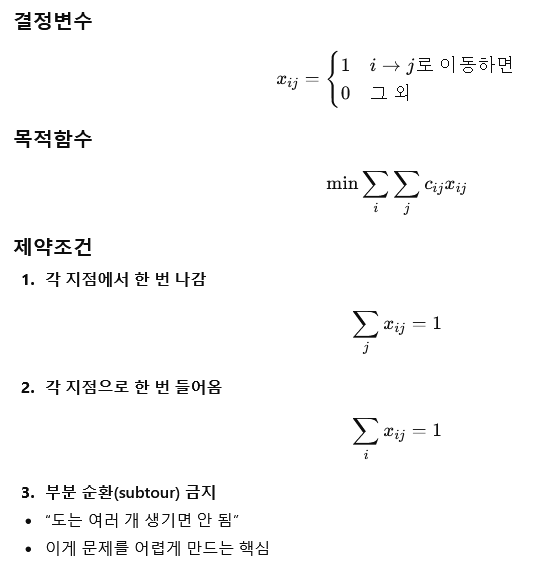

[TSP 해결 알고리즘]

- 1) Heuristic algorithm : nearest neighbor 방법을 사용하여, 현재 위치에서 가장 가까운 미방문 지점으로 이동

- 2) Local Search : 이미 존재하는 경로를 수정하여 개선 (2-opt를 많이 사용)

- 3) Metaheuristics : 여러가지 문제를 한꺼번에 고려하여 확률적으로 탐색

#### 1.1 샘플 데이터 생성

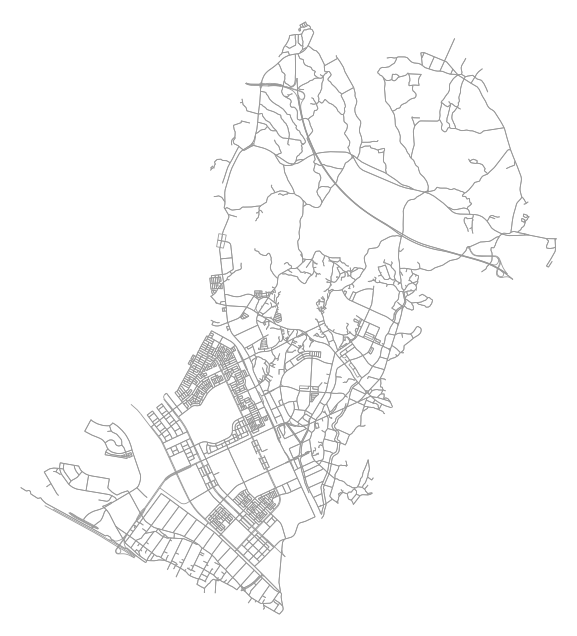

노드 수: 2341
엣지 수: 6456


In [3]:
# 기본 설정
ox.settings.use_cache = True
ox.settings.log_console = True

# 도시 이름
place_name = "Ilsandong-gu, Goyang-si, South Korea"

# 도로 네트워크 (network_type에 따라 보행, 차량용 으로 구분가능)
G = ox.graph_from_place(place_name, network_type="drive")

# 시각화
fig, ax = ox.plot_graph(
    G,
    node_size=0,
    edge_linewidth=0.6,
    bgcolor="white"
)

print(f"노드 수: {len(G.nodes)}")
print(f"엣지 수: {len(G.edges)}")

In [10]:
N=10
seed=42

nodes = list(G.nodes())
if len(nodes) < N:
    raise ValueError(f"Graph has only {len(nodes)} nodes, but N={N} was requested.")

sample_nodes = random.sample(nodes, N)

rows = []
for pt_id, node_id in enumerate(sample_nodes):
    nd = G.nodes[node_id]
    # OSMnx node attributes usually include 'x' (lon or projected x), 'y' (lat or projected y)
    rows.append({
        "pt_id": pt_id,
        "node_id": node_id,
        "x": nd.get("x"),
        "y": nd.get("y"),
        # Optional extras if present
        "street_count": nd.get("street_count"),
    })

points_df = pd.DataFrame(rows)

# -----------------------
print("Sampled nodes:", sample_nodes)
display(points_df)

Sampled nodes: [4711514176, 11370689797, 5172386384, 11383474019, 4790160837, 6518850374, 4642098024, 2094043166, 7868195257, 11377005951]


,pt_id,node_id,x,y,street_count
0,0,4711514176,126.797170,37.688690,3
1,1,11370689797,126.791687,37.684593,3
2,2,5172386384,126.807252,37.664092,3
3,3,11383474019,126.823684,37.689661,1
4,4,4790160837,126.790230,37.640617,4
5,5,6518850374,126.787631,37.660311,3
6,6,4642098024,126.760840,37.656931,3
7,7,2094043166,126.787844,37.683940,3
8,8,7868195257,126.780123,37.672437,3
9,9,11377005951,126.773858,37.635449,1


<Axes: xlabel='x', ylabel='y'>

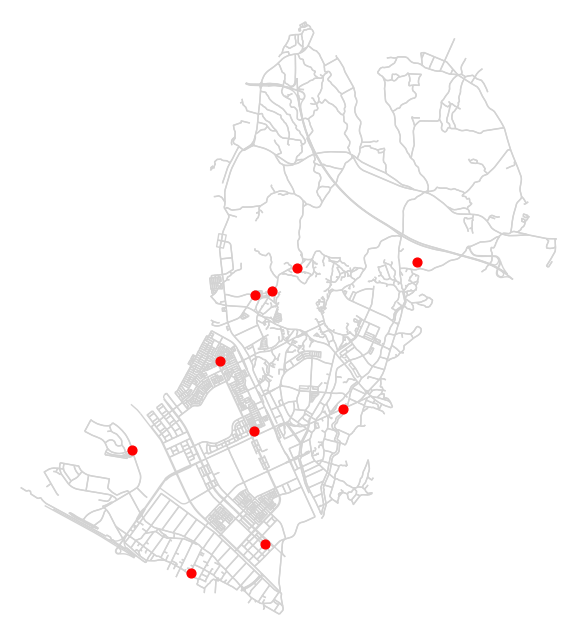

In [14]:
fig, ax = ox.plot_graph(
    G,
    show=False,
    close=False,
    node_size=0,
    bgcolor="white",
    edge_color="lightgray"
)

points_df.plot(
    ax=ax,
    x="x",
    y="y",
    kind="scatter",
    s=40,
    color="red",
    zorder=3
)

- 실제 도로망에서 모든 노드에 대하여, 직접 TSP를 계산하는 것은 비효율적임.

- 따라서 필수 방문 노드를 지정해서 노드간 최단거리를 구한뒤, 이를 바탕으로 TSP를 해결

- 즉, 실제 네트워크 위에 상위 위계의 네트워크를 설정

#### 1.2 노드간 OD 네트워크 생성

In [15]:
def compute_od_matrix(G, node_ids, weight="length"):
    """
    Compute OD shortest path distance matrix among node_ids on graph G.

    Parameters
    ----------
    G : networkx.MultiDiGraph / MultiGraph
        OSMnx graph.
    node_ids : list
        List of node IDs in the graph.
    weight : str
        Edge attribute used as weight (default 'length').

    Returns
    -------
    od_df : pd.DataFrame
        OD matrix with rows/cols labeled by node_id.
        Value is shortest-path distance (same unit as `weight`, usually meters).
        Unreachable pairs are np.inf.
    """
    node_ids = list(node_ids)
    n = len(node_ids)

    # Pre-allocate
    od = np.full((n, n), np.inf, dtype=float)
    np.fill_diagonal(od, 0.0)

    # Compute shortest paths from each origin to all nodes (single-source Dijkstra)
    # This is efficient enough for N=10.
    for i, src in enumerate(node_ids):
        dist_dict = nx.single_source_dijkstra_path_length(G, src, weight=weight)
        for j, dst in enumerate(node_ids):
            if dst in dist_dict:
                od[i, j] = float(dist_dict[dst])

    od_df = pd.DataFrame(od, index=node_ids, columns=node_ids)
    return od_df


In [16]:
# ---- Run (using your sampled nodes) ----
node_ids = points_df["node_id"].tolist()
od_df = compute_od_matrix(G, node_ids, weight="length")

# Optional: also keep a pt_id-labeled matrix for convenience
pt_labels = points_df["pt_id"].astype(str).tolist()
od_pt_df = pd.DataFrame(od_df.values, index=pt_labels, columns=pt_labels)

display(od_df)
# display(od_pt_df)

,4711514176,11370689797,5172386384,11383474019,4790160837,6518850374,4642098024,2094043166,7868195257,11377005951
4711514176,0.000000,738.625514,4204.305521,4037.889641,6750.029736,4086.139561,8163.256724,1131.125520,3069.162726,7873.738599
11370689797,738.625514,0.000000,3465.680007,4776.515155,6011.404222,3347.514047,7424.631209,392.500005,2330.537212,7135.113085
5172386384,4204.305521,3465.680007,0.000000,3612.850170,3779.781162,2064.440758,5982.329755,3534.220120,3404.497318,5074.836337
11383474019,4037.889641,4776.515155,3612.850170,0.000000,7381.713800,5666.373396,9584.262393,5169.015160,5793.623485,8676.768975
4790160837,6739.384836,6000.759322,3765.344700,7367.277338,0.000000,2648.028337,4567.643675,5932.329628,4117.474922,2269.649990
6518850374,4091.415517,3352.790003,2228.824139,5830.756777,3302.536350,0.000000,4787.058142,3284.360309,1607.435846,4424.811479
4642098024,8276.948285,7538.322771,6063.190997,9665.123635,4551.345847,4355.414021,0.000000,7469.893077,5575.198203,3360.557070
2094043166,1131.125520,392.500005,3571.096092,5169.015160,5979.850501,3315.960326,7393.077488,0.000000,2298.983490,7103.559363
7868195257,3069.162726,2330.537212,3426.428665,5793.623485,4132.382408,1638.322068,5464.200155,2262.107518,0.000000,5254.657538
11377005951,8001.043373,7262.417859,5074.836337,8676.768975,2253.352161,3957.519974,3360.557070,7193.988165,5378.808035,0.000000


In [17]:
# ---- Quick diagnostics ----
# 1) Check asymmetry (drive networks can be asymmetric)
asym_max = np.nanmax(np.abs(od_df.values - od_df.values.T))
print("Max |OD - OD^T|:", asym_max)

# 2) Check unreachable pairs
n_inf = np.isinf(od_df.values).sum()
print("Number of unreachable OD pairs (inf):", int(n_inf))

Max |OD - OD^T|: 654.5080135048042
Number of unreachable OD pairs (inf): 0


#### 1.3 Nearest Neighbor로 접근하는 TSP

In [18]:
def tsp_nearest_neighbor(od_df: pd.DataFrame, start=0):
    """
    Solve a TSP tour using Nearest Neighbor heuristic on an OD matrix.

    Parameters
    ----------
    od_df : pd.DataFrame
        Square OD cost matrix. Index/columns must match (same labels).
        Values should be finite; np.inf is allowed for unreachable pairs.
    start : int | str
        Starting node label (must exist in od_df.index).

    Returns
    -------
    tour : list
        Node labels in visit order, including return to start at the end.
        e.g., [start, ..., start]
    total_cost : float
        Sum of OD costs along the tour.
    """
    if not isinstance(od_df, pd.DataFrame):
        raise TypeError("od_df must be a pandas DataFrame")
    if list(od_df.index) != list(od_df.columns):
        raise ValueError("od_df index/columns must be identical and in the same order")

    nodes = list(od_df.index)
    if start not in nodes:
        raise ValueError(f"start={start} not found in od_df index")

    unvisited = set(nodes)
    unvisited.remove(start)

    tour = [start]
    current = start
    total_cost = 0.0

    while unvisited:
        # Choose the nearest unvisited node from current
        row = od_df.loc[current, list(unvisited)]

        # If there are unreachable nodes from current, they will be inf.
        next_node = row.idxmin()
        best_cost = float(row.loc[next_node])

        if not np.isfinite(best_cost):
            raise RuntimeError(
                f"Unreachable step: from {current} to any of {sorted(unvisited)} "
                f"(all costs are inf). Graph may be disconnected or OD matrix incomplete."
            )

        tour.append(next_node)
        total_cost += best_cost
        unvisited.remove(next_node)
        current = next_node

    # Return to start
    back_cost = float(od_df.loc[current, start])
    if not np.isfinite(back_cost):
        raise RuntimeError(f"Cannot return to start: {current} -> {start} is inf/unreachable.")
    tour.append(start)
    total_cost += back_cost

    return tour, total_cost


In [19]:
start_node = od_df.index[0]
tour, cost = tsp_nearest_neighbor(od_df, start=start_node)
print("Tour:", tour)
print("Total cost:", cost)

Tour: [np.int64(4711514176), np.int64(11370689797), np.int64(2094043166), np.int64(7868195257), np.int64(6518850374), np.int64(5172386384), np.int64(11383474019), np.int64(4790160837), np.int64(11377005951), np.int64(4642098024), np.int64(4711514176)]
Total cost: 32198.974531575277


##### 1.3.1 시각화

In [23]:
tour_nodes = [int(x) for x in tour]  # np.int64 -> int 캐스팅(안전)

route_nodes = []
for i in range(len(tour_nodes) - 1):
    src_node = tour_nodes[i]
    dst_node = tour_nodes[i + 1]

    path = nx.shortest_path(G, src_node, dst_node, weight="length")

    if i == 0:
        route_nodes.extend(path)
    else:
        route_nodes.extend(path[1:])

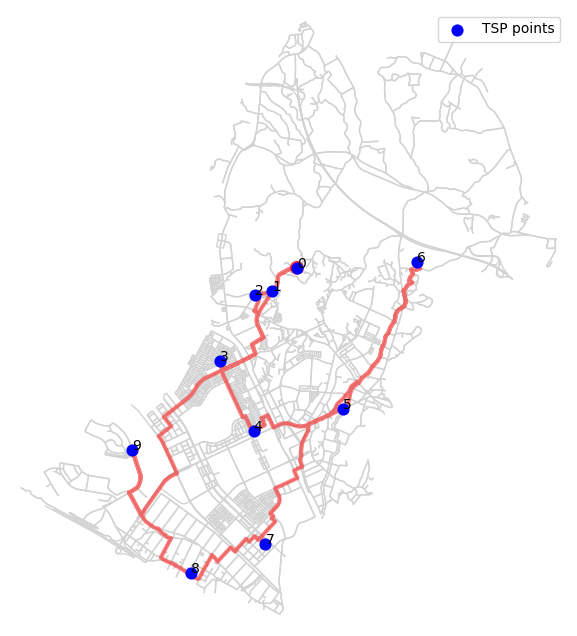

In [42]:

fig, ax = ox.plot_graph_route(
    G,
    route_nodes,
    route_color="red",
    route_linewidth=3,
    node_size=0,
    edge_color="lightgray",
    bgcolor="white",
    show=False,
    close=False
)

# 샘플 포인트 좌표
xs = points_df["x"].values
ys = points_df["y"].values

ax.scatter(
    xs,
    ys,
    c="blue",
    s=60,
    zorder=5,
    label="TSP points"
)

# 라벨 표시 (선택)
for order, nid in enumerate(tour[:-1]):
    nd = G.nodes[int(nid)]
    ax.text(nd["x"], nd["y"], str(order), fontsize=10, zorder=6)

ax.legend()

- Nearest neighbor는 greedy한 탐색을 추구함. 즉, 매 단계에서 제일 가까운 곳만을 확인함.

=> 나중에 돌아오는 비용을 계산하지 않음

- NN은 0->1->2 의 순서만 계산함. 1->2까지 어떻게 가느냐는 최단경로(Dijkstra)문제

#### 1.4 2-opt로 접근하는 TSP

In [43]:
def tour_cost(tour, od_df: pd.DataFrame) -> float:
    """tour: list of labels (must be in od_df.index). closed tour recommended."""
    c = 0.0
    for a, b in zip(tour[:-1], tour[1:]):
        w = float(od_df.loc[a, b])
        if not np.isfinite(w):
            return float("inf")
        c += w
    return c

def two_opt(tour, od_df: pd.DataFrame, max_iters: int = 1000):
    """
    2-opt improvement for a (closed) TSP tour.
    - tour: list like [s, ..., s]
    - od_df: OD matrix (DataFrame) with matching labels
    Returns: (best_tour, best_cost)
    """
    if tour[0] != tour[-1]:
        tour = tour + [tour[0]]

    best = list(tour)
    best_cost = tour_cost(best, od_df)

    n = len(best) - 1  # exclude last duplicate start

    improved = True
    it = 0
    while improved and it < max_iters:
        improved = False
        it += 1

        # i and k are cut points; we reverse segment [i:k]
        for i in range(1, n - 1):
            for k in range(i + 1, n):
                a, b = best[i - 1], best[i]
                c, d = best[k], best[(k + 1) % n]  # next after k (wrap to start)

                # current edges: a->b and c->d
                # new edges: a->c and b->d
                old = float(od_df.loc[a, b]) + float(od_df.loc[c, d])
                new = float(od_df.loc[a, c]) + float(od_df.loc[b, d])

                # skip if unreachable
                if not np.isfinite(old) or not np.isfinite(new):
                    continue

                if new + 1e-12 < old:
                    # apply 2-opt reversal
                    best[i:k+1] = reversed(best[i:k+1])
                    best_cost = best_cost - old + new
                    improved = True
                    break
            if improved:
                break

    return best, best_cost

In [44]:
tour_2opt, cost_2opt = two_opt(tour, od_df)
print("Before:", tour_cost(tour, od_df))
print("After :", cost_2opt)

Before: 32198.974531575277
After : 26634.520049993203


In [46]:
def plot_tour_osm(G, points_df, tour, weight="length",
                 route_color="red", route_linewidth=3):
    """
    Plot a tour (pt_id or node_id) on an OSMnx graph with visit-order labels.
    points_df must have: pt_id, node_id
    """
    pt_set = set(points_df["pt_id"].astype(int).tolist())
    pt_to_node = dict(zip(points_df["pt_id"].astype(int), points_df["node_id"].astype(int)))
    node_to_pt = dict(zip(points_df["node_id"].astype(int), points_df["pt_id"].astype(int)))

    tour_list = [int(x) for x in tour]

    # convert to node_id tour
    if all(t in pt_set for t in tour_list):
        tour_node_ids = [pt_to_node[t] for t in tour_list]
    else:
        tour_node_ids = tour_list

    # ensure closed
    if tour_node_ids[0] != tour_node_ids[-1]:
        tour_node_ids = tour_node_ids + [tour_node_ids[0]]

    # expand into full road route
    route_nodes = []
    for i in range(len(tour_node_ids) - 1):
        src = tour_node_ids[i]
        dst = tour_node_ids[i + 1]
        path = nx.shortest_path(G, src, dst, weight=weight)
        route_nodes.extend(path if i == 0 else path[1:])

    # plot route
    fig, ax = ox.plot_graph_route(
        G, route_nodes,
        route_color=route_color,
        route_linewidth=route_linewidth,
        node_size=0,
        edge_color="lightgray",
        bgcolor="white",
        show=False,
        close=False
    )

    # plot points (sample nodes)
    xs, ys = [], []
    for nid in points_df["node_id"].astype(int).tolist():
        nd = G.nodes[nid]
        xs.append(nd["x"]); ys.append(nd["y"])
    ax.scatter(xs, ys, s=60, zorder=5, label="TSP points")

    # visit-order labels on the actual visited nodes
    visit_order = {nid: i for i, nid in enumerate(tour_node_ids[:-1])}
    for nid, order in visit_order.items():
        nd = G.nodes[int(nid)]
        ax.text(nd["x"], nd["y"], str(order), fontsize=10, color="black", zorder=6)

    ax.legend()
    return fig, ax

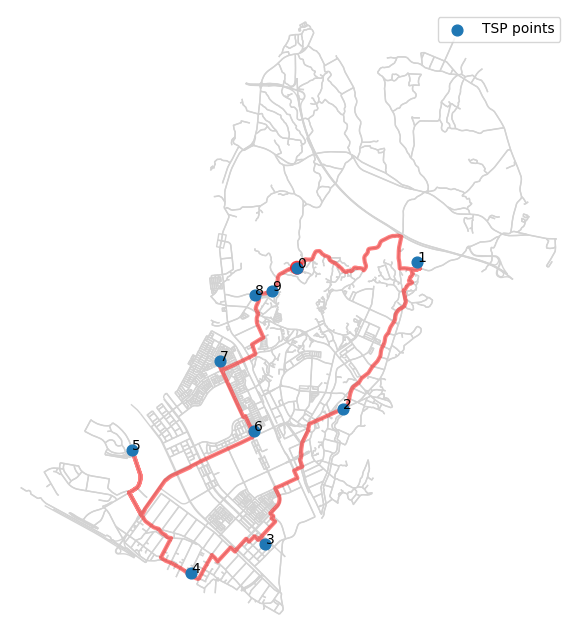

In [48]:
fig2, ax2 = plot_tour_osm(G, points_df, tour_2opt, weight="length")

- NN TSP보다 체감되는 개선폭이 큼. 돌아오는 경로를 고려하면서 겹치는 경로를 최소화 하는 2-opt 방식이기 때문(교차/지그재그 등의 경로를 개선)

- 그러나, 이러한 방법이 항상 최적의 해가 되는 것은 아님. 경로 설정은 지나야 하는 필수 노드와 전체 도로망 노드가 넓어짐에 따라 연산량이 매우 증가하고 복잡해짐.

- 특히, 실제 적용에 있어서는 이용자의 납득가능성, 연산속도, 결과 안전성 등을 고려해야함.

- NN + 2-opt 와 같은 방법은 결국 최적 경로 발견의 초기해로서 사용될 수 있음.